In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
from torch.utils.data import DataLoader
import time
import copy
from tqdm.notebook import tqdm

In [2]:
# Check if CUDA is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Set random seed for reproducibility
torch.manual_seed(42)
if torch.cuda.is_available():
    torch.cuda.manual_seed(42)

# Define transforms
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

Using device: cpu


In [3]:
# Load CIFAR-10 dataset
trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

trainloader = DataLoader(trainset, batch_size=128, shuffle=True, num_workers=2)
testloader = DataLoader(testset, batch_size=128, shuffle=False, num_workers=2)

# Define the classes
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

In [4]:
# Define a simple CNN model
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, 3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, 3, padding=1)
        self.conv3 = nn.Conv2d(64, 128, 3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(128 * 4 * 4, 512)
        self.fc2 = nn.Linear(512, 10)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.2)

    def forward(self, x):
        x = self.pool(self.relu(self.conv1(x)))
        x = self.pool(self.relu(self.conv2(x)))
        x = self.pool(self.relu(self.conv3(x)))
        x = x.view(-1, 128 * 4 * 4)
        x = self.dropout(self.relu(self.fc1(x)))
        x = self.fc2(x)
        return x

In [5]:
# Create the model
model1 = SimpleCNN().to(device)
model2 = SimpleCNN().to(device)  # For adversarial training

# Loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer1 = optim.Adam(model1.parameters(), lr=0.001)
optimizer2 = optim.Adam(model2.parameters(), lr=0.001)

In [6]:
# Function to calculate accuracy
def calculate_accuracy(model, dataloader):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for data in dataloader:
            images, labels = data
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    return 100 * correct / total

In [7]:
# Function to create adversarial examples using Fast Gradient Sign Method (FGSM)
def create_adversarial_examples(model, images, labels, epsilon=0.03):
    images.requires_grad = True

    outputs = model(images)
    loss = criterion(outputs, labels)
    model.zero_grad()
    loss.backward()

    # Create adversarial examples
    data_grad = images.grad.data
    sign_data_grad = data_grad.sign()
    perturbed_images = images + epsilon * sign_data_grad

    # Clip to ensure valid pixel range [0,1]
    perturbed_images = torch.clamp(perturbed_images, -1, 1)

    return perturbed_images

In [8]:
# Train the first model (standard training)
def train_standard_model(model, optimizer, num_epochs=10):
    print("Training standard model...")
    model.train()
    history = {'train_loss': [], 'train_acc': [], 'val_acc': []}

    for epoch in range(num_epochs):
        running_loss = 0.0
        for i, data in tqdm(enumerate(trainloader, 0), total=len(trainloader)):
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()

            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

        # Calculate metrics
        train_acc = calculate_accuracy(model, trainloader)
        val_acc = calculate_accuracy(model, testloader)

        history['train_loss'].append(running_loss / len(trainloader))
        history['train_acc'].append(train_acc)
        history['val_acc'].append(val_acc)

        print(f'Epoch {epoch+1}/{num_epochs}, Loss: {running_loss/len(trainloader):.4f}, Train Acc: {train_acc:.2f}%, Val Acc: {val_acc:.2f}%')

    return history

In [9]:
# Train the second model (adversarial training)
def train_adversarial_model(model, optimizer, num_epochs=10, epsilon=0.03):
    print("Training adversarial model...")
    model.train()
    history = {'train_loss': [], 'train_acc': [], 'val_acc': [], 'adv_val_acc': []}

    for epoch in range(num_epochs):
        running_loss = 0.0
        for i, data in tqdm(enumerate(trainloader, 0), total=len(trainloader)):
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)

            # Create adversarial examples
            adv_inputs = create_adversarial_examples(model, inputs, labels, epsilon)

            optimizer.zero_grad()

            # Train on a mix of clean and adversarial examples
            outputs_clean = model(inputs)
            loss_clean = criterion(outputs_clean, labels)

            outputs_adv = model(adv_inputs)
            loss_adv = criterion(outputs_adv, labels)

            # Combined loss
            loss = 0.5 * loss_clean + 0.5 * loss_adv

            loss.backward()
            optimizer.step()

            running_loss += loss.item()

        # Calculate metrics
        train_acc = calculate_accuracy(model, trainloader)
        val_acc = calculate_accuracy(model, testloader)

        # Generate adversarial examples for the validation set and measure accuracy
        adv_val_acc = calculate_adversarial_accuracy(model, testloader, epsilon)

        history['train_loss'].append(running_loss / len(trainloader))
        history['train_acc'].append(train_acc)
        history['val_acc'].append(val_acc)
        history['adv_val_acc'].append(adv_val_acc)

        print(f'Epoch {epoch+1}/{num_epochs}, Loss: {running_loss/len(trainloader):.4f}, Train Acc: {train_acc:.2f}%, Val Acc: {val_acc:.2f}%, Adv Val Acc: {adv_val_acc:.2f}%')

    return history

In [10]:
# Function to calculate accuracy on adversarial examples
def calculate_adversarial_accuracy(model, dataloader, epsilon=0.03):
    model.eval()
    correct = 0
    total = 0

    for data in dataloader:
        images, labels = data
        images, labels = images.to(device), labels.to(device)

        # Create adversarial examples
        adv_images = create_adversarial_examples(model, images, labels, epsilon)

        outputs = model(adv_images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    return 100 * correct / total


In [11]:
# Train the models
print("Step 1: Training standard model with clean data...")
model1_history = train_standard_model(model1, optimizer1, num_epochs=5)

print("\nStep 2: Training adversarial model...")
model2_history = train_adversarial_model(model2, optimizer2, num_epochs=5)

Step 1: Training standard model with clean data...
Training standard model...


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch 1/5, Loss: 1.4579, Train Acc: 60.01%, Val Acc: 58.94%


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch 2/5, Loss: 0.9941, Train Acc: 69.86%, Val Acc: 66.51%


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch 3/5, Loss: 0.7899, Train Acc: 76.55%, Val Acc: 71.98%


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch 4/5, Loss: 0.6619, Train Acc: 80.68%, Val Acc: 73.48%


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch 5/5, Loss: 0.5481, Train Acc: 83.93%, Val Acc: 74.65%

Step 2: Training adversarial model...
Training adversarial model...


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch 1/5, Loss: 1.6886, Train Acc: 55.86%, Val Acc: 54.63%, Adv Val Acc: 37.83%


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch 2/5, Loss: 1.3758, Train Acc: 65.72%, Val Acc: 62.71%, Adv Val Acc: 40.44%


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch 3/5, Loss: 1.2225, Train Acc: 71.82%, Val Acc: 66.89%, Adv Val Acc: 43.40%


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch 4/5, Loss: 1.1044, Train Acc: 77.43%, Val Acc: 70.14%, Adv Val Acc: 44.32%


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch 5/5, Loss: 1.0092, Train Acc: 79.76%, Val Acc: 70.44%, Adv Val Acc: 45.64%


In [12]:
# Save models
torch.save(model1.state_dict(), 'standard_model.pth')
torch.save(model2.state_dict(), 'adversarial_model.pth')

In [ ]:
# Evaluate models on clean and adversarial test data
std_model_clean_acc = calculate_accuracy(model1, testloader)
adv_model_clean_acc = calculate_accuracy(model2, testloader)
std_model_adv_acc = calculate_adversarial_accuracy(model1, testloader)  # Added this line
adv_model_adv_acc = calculate_adversarial_accuracy(model2, testloader)

print(f"\nStandard Model - Clean Accuracy: {std_model_clean_acc:.2f}%")
print(f"Standard Model - Adversarial Accuracy: {std_model_adv_acc:.2f}%")  # Added this line
print(f"Adversarial Model - Clean Accuracy: {adv_model_clean_acc:.2f}%")
print(f"Adversarial Model - Adversarial Accuracy: {adv_model_adv_acc:.2f}%")



Standard Model - Clean Accuracy: 74.65%
Standard Model - Adversarial Accuracy: 21.34%
Adversarial Model - Clean Accuracy: 70.44%
Adversarial Model - Adversarial Accuracy: 45.64%


: 

In [ ]:
# Plot 1: Prediction accuracy of clean data on both models
plt.figure(figsize=(10, 6))
plt.bar(['Standard Model', 'Adversarial Model'], [std_model_clean_acc, adv_model_clean_acc], color=['blue', 'green'])
plt.title('Accuracy Comparison on Clean Data')
plt.ylabel('Accuracy (%)')
plt.grid(axis='y', linestyle='--', alpha=0.7)
for i, v in enumerate([std_model_clean_acc, adv_model_clean_acc]):
    plt.text(i, v+1, f"{v:.2f}%", ha='center')
plt.savefig('plot1_clean_data_comparison.png')
plt.show()

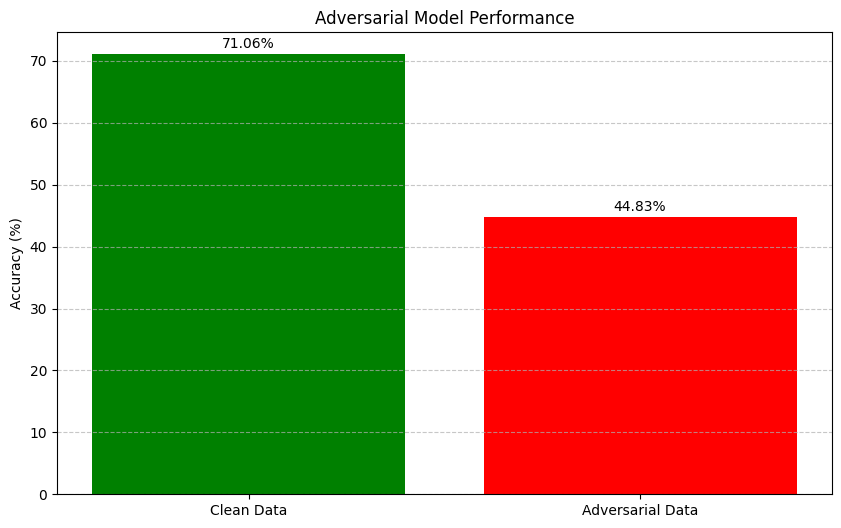

In [ ]:
# Plot 2: Adversarial model performance on clean vs adversarial data
plt.figure(figsize=(10, 6))
plt.bar(['Clean Data', 'Adversarial Data'], [adv_model_clean_acc, adv_model_adv_acc], color=['green', 'red'])
plt.title('Adversarial Model Performance')
plt.ylabel('Accuracy (%)')
plt.grid(axis='y', linestyle='--', alpha=0.7)
for i, v in enumerate([adv_model_clean_acc, adv_model_adv_acc]):
    plt.text(i, v+1, f"{v:.2f}%", ha='center')
plt.savefig('plot2_adversarial_model_performance.png')
plt.show()

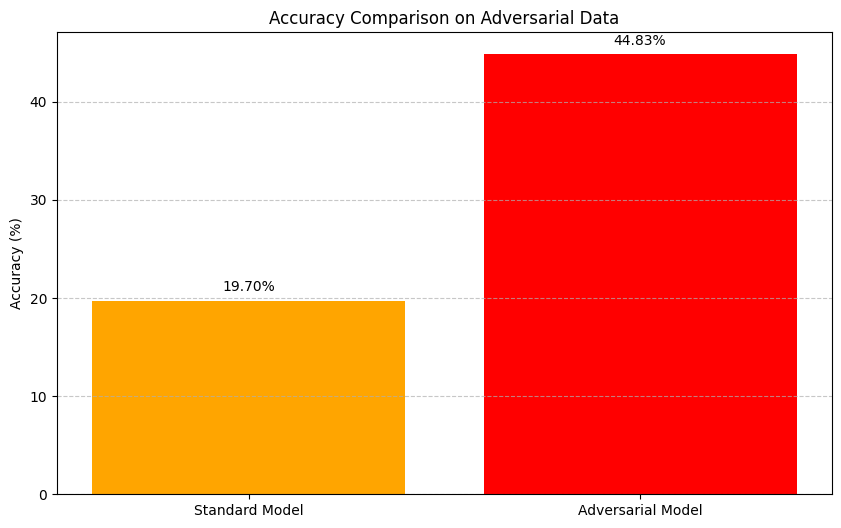

In [ ]:
# Plot 3: Comparing standard model vs adversarial model on adversarial data
plt.figure(figsize=(10, 6))
plt.bar(['Standard Model', 'Adversarial Model'], [std_model_adv_acc, adv_model_adv_acc], color=['orange', 'red'])
plt.title('Accuracy Comparison on Adversarial Data')
plt.ylabel('Accuracy (%)')
plt.grid(axis='y', linestyle='--', alpha=0.7)
for i, v in enumerate([std_model_adv_acc, adv_model_adv_acc]):
    plt.text(i, v+1, f"{v:.2f}%", ha='center')
plt.savefig('plot4_adversarial_data_comparison.png')
plt.show()